# Using `ez_zarr` to explore individual OME-Zarr images

Silvia Barbiero, Michael Stadler, Charlotte Soneson

# Goal

The aim of `ez_zarr` is to provide easy, high-level access to microscopy
data, stored in OME-Zarr format according to the
[NGFF](https://ngff.openmicroscopy.org/latest/) specifications.

In addition to the python package, we also provide an R package that
automatically generates and wraps a python environment with `ez_zarr`
and all dependencies, available at https://github.com/fmicompbio/ezzarr.

The `ome_zarr.Image` class represents an individual image and provides
methods to obtain metadata, extract image or label arrays and visualize
these. Below we illustrate the use of `ome_zarr.Image` objects by
examples.

# Using `ome_zarr.Image` objects

Note: If you prefer to run these examples interactively, you can also
download them as an [ipynb
notebook](https://fmicompbio.github.io/ez_zarr/getting_started_Image.ipynb).

Here are some examples of how you can use `ome_zarr.Image` objects
defined in `ez_zarr`:

## Download example data

To run the code below, you will first need to download some image data.
You can do this for example by running the following from a terminal:

``` bash
# Download small Fractal output from Zenodo
curl -o temp.zip https://zenodo.org/records/10519143/files/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr.zip

# Unzip and remove the temporary zip file
unzip temp.zip
rm temp.zip
```

or directly from within a python notebook or session using:

In [1]:
import pandas as pd
import requests
import zipfile
import tempfile
import shutil
import os
import sys

# for info on data see: https://zenodo.org/records/10257149
url = 'https://zenodo.org/records/10519143/files/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr.zip'

# download
response = requests.get(url)
with open('temp.zip', 'wb') as temp_zip:
    temp_zip.write(response.content)

# unzip to current directory
with zipfile.ZipFile('temp.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# clean up
os.remove('temp.zip')

## Load packages

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from skimage import color

from ez_zarr import ome_zarr, plotting, utils

## Open OME-Zarr file set

We open a single OME-Zarr image:

In [3]:
img_directory = '20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0'
img = ome_zarr.Image(path = img_directory, name = 'cardio-d14')
img

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/zarr/core/group.py:3530: ZarrUserWarning: Object at .DS_Store is not recognized as a component of a Zarr hierarchy.
  warnings.warn(
/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/zarr/core/group.py:3530: ZarrUserWarning: Object at empty_well_ROI_table_0_True_0_0 is not recognized as a component of a Zarr hierarchy.
  warnings.warn(
/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/zarr/core/group.py:3530: ZarrUserWarning: Object at empty_well_ROI_table_1_True_0_0 is not recognized as a component of a Zarr hierarchy.
  warnings.warn(
/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/zarr/core/group.py:3530: ZarrUserWarning: Object at table_well_ROI_table_3_False_0_0 is not recognized as a component of a Zarr hierarchy.
  warnings.warn(
/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/zarr/core/group.py:3530: ZarrUserWarning: Object at empt

Image cardio-d14
  path: 20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0
  n_channels: 1 (DAPI)
  n_pyramid_levels: 5
  pyramid_zyx_scalefactor: [1. 2. 2.]
  full_resolution_zyx_spacing (micrometer): [1.0, 0.1625, 0.1625]
  segmentations: empty, nuclei
  tables (measurements): well_ROI_table, expected_table_well_ROI_table_0_True_0_0, expected_table_well_ROI_table_3_False_0_0, expected_table_masked_nuclei_ROI_table_1_True_0_0, nuclei_ROI_table, expected_table_well_ROI_table_3_True_0_0, expected_table_FOV_ROI_table_1_False_0_0, expected_table_masked_nuclei_ROI_table_0_True_0_0, nuclei, FOV_ROI_table, expected_table_FOV_ROI_table_1_True_0_0

`img` represents a maximum intensity projection of one well from a
high-content screening plate, processed using
[Fractal](https://fractal-analytics-platform.github.io/). In addition to
such images with two spatial dimensions, `ez-zarr` supports OME-Zarr
images with any number of dimensions, automatically projecting images
with more than two spatial dimensions for plotting.

In `img`, there are 5 `pyramid_levels` available (0 to 4), meaning that
in addition to the full resolution data (level 0), we have four more
levels that provide the data in 2-fold lower resolutions (see
`pyramid_zyx_scalefactor`), for example for faster plotting.

This OME-Zarr image also contains two segmentations (`empty` and
`nuclei`), and for one measurements have been extracted and saved in the
table `nuclei`. In addition, there are some further tables, such as
`FOV_ROI_table`, which contains the coordinates of the fields of view,
or `nuclei_ROI_table`, which contains the bounding box coordinates for
the segmented nuclei.

## Get information from `img`

You can obtain specific information on the content available in the
image:

In [4]:
# path to the OME-Zarr image
img.get_path()

'20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0'

In [5]:
# available channels
img.get_channels()

[{'color': '00FFFF',
  'label': 'DAPI',
  'wavelength_id': 'A01_C01',
  'window': {'end': 800, 'max': 65535, 'min': 0, 'start': 110}}]

In [6]:
# available labels
img.get_label_names()

['empty', 'nuclei']

In [7]:
# available tables
img.get_table_names()

['well_ROI_table',
 'expected_table_well_ROI_table_0_True_0_0',
 'expected_table_well_ROI_table_3_False_0_0',
 'expected_table_masked_nuclei_ROI_table_1_True_0_0',
 'nuclei_ROI_table',
 'expected_table_well_ROI_table_3_True_0_0',
 'expected_table_FOV_ROI_table_1_False_0_0',
 'expected_table_masked_nuclei_ROI_table_0_True_0_0',
 'nuclei',
 'FOV_ROI_table',
 'expected_table_FOV_ROI_table_1_True_0_0']

In [8]:
# zyx pixel spacing in micrometers for pyramid levels
# ... for images (channels, z, y, x)
img.get_scale(pyramid_level='0')

[1, 1.0, 0.1625, 0.1625]

In [9]:
# ... for labels (z, y, x)
img.get_scale(pyramid_level='0', label_name='nuclei')

[1.0, 0.65, 0.65]

In [10]:
# tree of folder and file structure in the zarr group
print(img.tree(level=3))

/ 
├── 0 (1, 1, 2160, 5120) uint16
├── 1 (1, 1, 1080, 2560) uint16
├── 2 (1, 1, 540, 1280) uint16
├── 3 (1, 1, 270, 640) uint16
├── 4 (1, 1, 135, 320) uint16
├── labels 
│ ├── empty 
│ │ ├── 0 (1, 540, 1280) uint32
│ │ ├── 1 (1, 270, 640) uint32
│ │ ├── 2 (1, 135, 320) uint32
│ │ ├── 3 (1, 67, 160) uint32
│ │ └── 4 (1, 33, 80) uint32
│ └── nuclei 
│ ├── 0 (1, 540, 1280) uint32
│ ├── 1 (1, 270, 640) uint32
│ ├── 2 (1, 135, 320) uint32
│ ├── 3 (1, 67, 160) uint32
│ └── 4 (1, 33, 80) uint32
└── tables 
 ├── FOV_ROI_table 
 │ ├── X (2, 8) float32
 │ ├── layers 
 │ ├── obs 
 │ │ └── FieldIndex (2,) object
 │ ├── obsm 
 │ ├── obsp 
 │ ├── uns 
 │ ├── var 
 │ │ └── _index (8,) object
 │ ├── varm 
 │ └── varp 
 ├── expected_table_FOV_ROI_table_1_False_0_0 
 │ ├── X (1504, 18) float32
 │ ├── layers 
 │ ├── obs 
 │ │ ├── ROI_name (1504,) object
 │ │ ├── ROI_table_name (1504,) object
 │ │ ├── _index (1504,) int64
 │ │ └── label (1504,) int64
 │ ├── obsm 
 │ ├── obsp 
 │ ├── uns 
 │ ├── var 
 │ │ └── _index (18,) object
 │ ├── varm 
 │ └── varp 
 ├── expected_table_FOV_ROI_table_1_True_0_0 
 │ ├── X (1504, 38) float32
 │ ├── layers 
 │ ├── obs 
 │ │ ├── ROI_name (1504,) object
 │ │ ├── ROI_table_name (1504,) object
 │ │ ├── _index (1504,) int64
 │ │ └── label (1504,) int64
 │ ├── obsm 
 │ ├── obsp 
 │ ├── uns 
 │ ├── var 
 │ │ └── _index (38,) object
 │ ├── varm 
 │ └── varp 
 ├── expected_table_masked_nuclei_ROI_table_0_True_0_0 
 │ ├── X (1493, 22) float32
 │ ├── layers 
 │ ├── obs 
 │ │ ├── ROI_label (1493,) int64
 │ │ ├── ROI_name (1493,) object
 │ │ ├── ROI_table_name (1493,) object
 │ │ ├── _index (1493,) int64
 │ │ └── label (1493,) int64
 │ ├── obsm 
 │ ├── obsp 
 │ ├── uns 
 │ ├── var 
 │ │ └── _index (22,) object
 │ ├── varm 
 │ └── varp 
 ├── expected_table_masked_nuclei_ROI_table_1_True_0_0 
 │ ├── X (1493, 38) float32
 │ ├── layers 
 │ ├── obs 
 │ │ ├── ROI_label (1493,) int64
 │ │ ├── ROI_name (1493,) object
 │ │ ├── ROI_table_name (1493,) object
 │ │ ├── _index (1493,) int64
 │ │ └── label (1493,) int64
 │ ├── obsm 
 │ ├── obsp 
 │ ├── uns 
 │ ├── var 
 │ │ └── _index (38,) object
 │ ├── varm 
 │ └── varp 
 ├── expected_table_well_ROI_table_0_True_0_0 
 │ ├── X (1493, 22) float32
 │ ├── layers 
 │ ├── obs 
 │ │ ├── ROI_name (1493,) object
 │ │ ├── ROI_table_name (1493,) object
 │ │ ├── _index (1493,) int64
 │ │ └── label (1493,) int64
 │ ├── obsm 
 │ ├── obsp 
 │ ├── uns 
 │ ├── var 
 │ │ └── _index (22,) object
 │ ├── varm 
 │ └── varp 
 ├── expected_table_well_ROI_table_3_False_0_0 
 │ ├── X (1493, 50) float32
 │ ├── layers 
 │ ├── obs 
 │ │ ├── ROI_name (1493,) object
 │ │ ├── ROI_table_name (1493,) object
 │ │ ├── _index (1493,) int64
 │ │ └── label (1493,) int64
 │ ├── obsm 
 │ ├── obsp 
 │ ├── uns 
 │ ├── var 
 │ │ └── _index (50,) object
 │ ├── varm 
 │ └── varp 
 ├── expected_table_well_ROI_table_3_True_0_0 
 │ ├── X (1493, 70) float32
 │ ├── layers 
 │ ├── obs 
 │ │ ├── ROI_name (1493,) object
 │ │ ├── ROI_table_name (1493,) object
 │ │ ├── _index (1493,) int64
 │ │ └── label (1493,) int64
 │ ├── obsm 
 │ ├── obsp 
 │ ├── uns 
 │ ├── var 
 │ │ └── _index (70,) object
 │ ├── varm 
 │ └── varp 
 ├── nuclei 
 │ ├── X (1493, 7) float32
 │ ├── layers 
 │ ├── obs 
 │ │ ├── _index (1493,) int64
 │ │ └── label (1493,) object
 │ ├── obsm 
 │ ├── obsp 
 │ ├── uns 
 │ ├── var 
 │ │ └── _index (7,) object
 │ ├── varm 
 │ └── varp 
 ├── nuclei_ROI_table 
 │ ├── X (1493, 6) float32
 │ ├── layers 
 │ ├── obs 
 │ │ ├── _index (1493,) object
 │ │ └── label (1493,) object
 │ ├── obsm 
 │ ├── obsp 
 │ ├── uns 
 │ ├── var 
 │ │ └── _index (6,) object
 │ ├── varm 
 │ └── varp 
 └── well_ROI_table 
 ├── X (1, 6) float32
 ├── layers 
 ├── obs 
 │ └── FieldIndex (1,) object
 ├── obsm 
 ├── obsp 
 ├── uns 
 ├── var 
 │ └── _index (6,) object
 ├── varm 
 └── varp

## Extract a table from the OME-Zarr image

At the time of writing, tabular data is not yet covered in the NGFF
standard. The tables stored within this OME-Zarr image are formatted as
described in the [Fractal
documentation](https://fractal-analytics-platform.github.io/fractal-tasks-core/tables/).

As mentioned the goal of `ez_zarr` is to abstract the internal structure
and make it simple to obtain these tables as a `pandas.DataFrame` :

In [11]:
df = img.get_table(table_name='FOV_ROI_table')
df

| FieldIndex | x_micrometer | y_micrometer | z_micrometer | len_x_micrometer | len_y_micrometer | len_z_micrometer | x_micrometer_original | y_micrometer_original |
|:------|------:|------:|------:|--------:|--------:|--------:|----------:|----------:|
| FOV_1 | 0 | 0 | 0 | 416 | 351 | 1 | -1448.3 | -1517.7 |
| FOV_2 | 416 | 0 | 0 | 416 | 351 | 1 | -1032.3 | -1517.7 |

or `anndata.AnnData` object:

In [13]:
ann = img.get_table(table_name='FOV_ROI_table', as_AnnData=True)
ann

AnnData object with n_obs × n_vars = 2 × 8

## Visualize the image

`get_array_by_coordinate()` extracts a rectangular region of interest
from an image by coordinates. If no coordinates or other arguments are
given, it returns the whole image at the lowest available resolution:

In [14]:
arr = img.get_array_by_coordinate()
print(arr.shape) # (ch, z, y, x)

(1, 1, 135, 320)

Such an image array can be easily plotted using
`matplotlib.pyplot.imshow`:

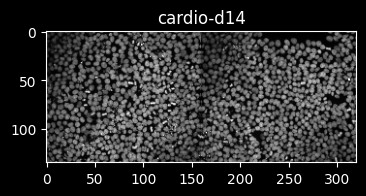

In [15]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(4, 4))
    fig.set_dpi(100)

    plt.imshow(arr[0,0], cmap='gray', vmin=100, vmax=600)
    plt.title(img.name)
    plt.show()
    plt.close()

With `plot()`, `ome_zarr.Image` provides a convenient function for this
that automatically extracts the well image and plots it. Because it has
access to the image metadata, it can also add for example a scale bar:

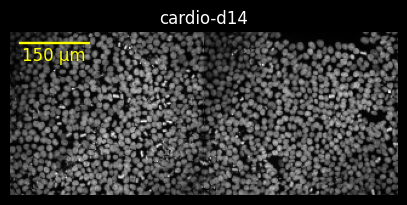

In [16]:
img.plot(channels=[0],
         channel_colors=['white'],
         channel_ranges=[[100, 600]],
         title=img.name,
         scalebar_micrometer=150,
         scalebar_color='yellow',
         scalebar_position='topleft',
         scalebar_label=True,
         fig_width_inch=5,
         fig_height_inch=4,
         fig_dpi=100)

`plot()` uses internally `ez_zarr.plotting.plot_image()` which is a
convenient wrapper around `matplotlib.pyplot.imshow`. `plot_image()` can
also be used directly if you want to work with image arrays (for
examples, see section “Working with segmentation masks” below).

## Zoom in

Let’s first show the coordinate axes for our image:

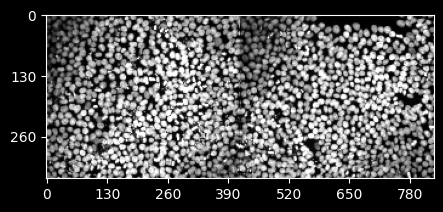

In [17]:
img.plot(axis_style='micrometer',
         fig_width_inch=5,
         fig_height_inch=4,
         fig_dpi=100)

Now we can zoom in by coordinates:

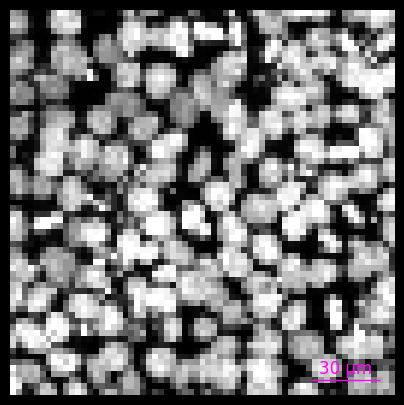

In [18]:
img.plot(upper_left_yx=(130, 140),
         lower_right_yx=(300, 310),
         scalebar_micrometer=30,
         scalebar_color='magenta',
         fig_width_inch=5,
         fig_height_inch=5,
         fig_dpi=100)

So far, we have been automatically using the lowest resolution pyramid
level version of the data, and the micrometer coordinates above have
been automatically converted to the corresponding pixel coordinates.

If we want to get the same image region at a higher resolution, we can
use the `pyramid_level` argument:

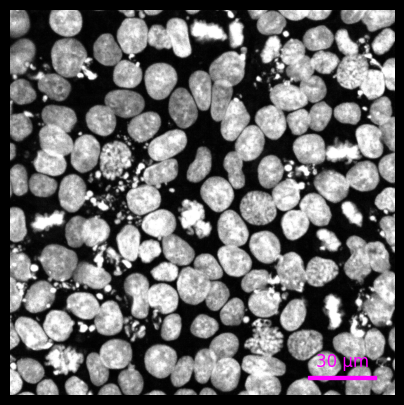

In [19]:
img.plot(pyramid_level=0,
         upper_left_yx=(130, 140),
         lower_right_yx=(300, 310),
         scalebar_micrometer=30,
         scalebar_color='magenta',
         fig_width_inch=5,
         fig_height_inch=5,
         fig_dpi=100)

You can see from the scale bar that again conversion from micrometer to
pixel coordinates are performed automatically.

If you prefer to work with pixel coordinates, for example for slicing
numpy arrays, `get_array_by_coordinate` or `plot` also support that.

Let’s first look at the full image at low resolution again, now using
pixel coordinates for the axes:

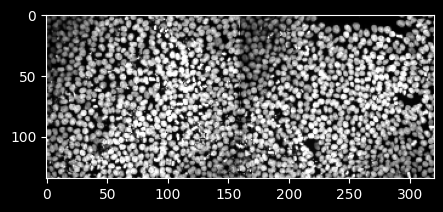

In [20]:
img.plot(axis_style='pixel',
         fig_width_inch=5,
         fig_height_inch=4,
         fig_dpi=100)

Now we zoom in using pixel coordinates (`coordinate_unit='pixel'`):

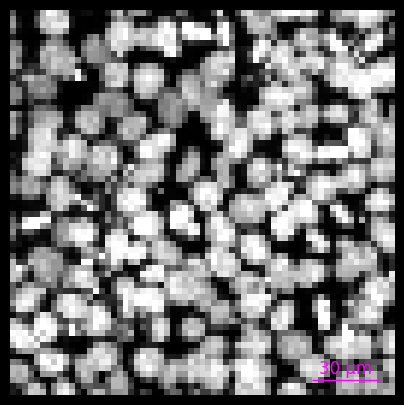

In [21]:
img.plot(coordinate_unit='pixel',
         upper_left_yx=(50, 56),
         lower_right_yx=(115, 121),
         scalebar_micrometer=30,
         scalebar_color='magenta',
         fig_width_inch=5,
         fig_height_inch=5,
         fig_dpi=100)

Again, we were automatically using the lowest resolution of the image,
and we can use `pyramid_level` to select a higher resolution. When
working with pixel coordinates, we will need to specify that our
coordinates still refer to the currently selected `pyramid_level` (4),
in order to obtain the same region of the image. This can be done using
the `pyramid_level_coord` argument:

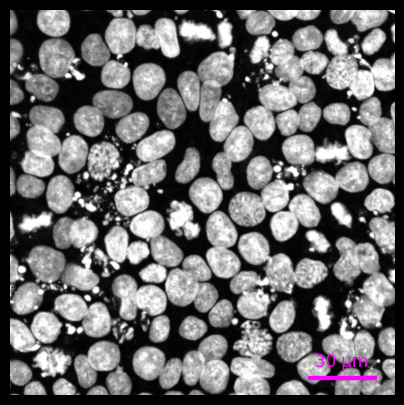

In [22]:
img.plot(coordinate_unit='pixel',
         pyramid_level=0,       # extract image from this level
         pyramid_level_coord=4, # coordinates refer to this level
         upper_left_yx=(50, 56),
         lower_right_yx=(115, 121),
         scalebar_micrometer=30,
         scalebar_color='magenta',
         fig_width_inch=5,
         fig_height_inch=5,
         fig_dpi=100)

## Coordinate conversions (usually done internally)

As mentioned the pixel coordinates depend on the `pyramid_level`. The
image metadata makes it easy to convert between pixel coordinates and
micrometer coordinates, or pixel coordinates referring to different
pyramid levels. The `get_array_by_coordinate` and `plot` methods do this
automatically.

You can do it also manually by using `get_scale` to obtain the pixel
sizes (in micrometer) from the image metadata, and
`ez_zarr.utils.convert_coordinates` to do the actual conversion:

In [23]:
# let's define some pixel coordinates referring to pyramid level 4
zyx_4 = (1, 230, 180)
print(f'starting coordinates (pixels in pyramid level 4): {zyx_4}')

# get pixel scale at pyramid level 4 (z, y, x)
s_4 = img.get_scale(pyramid_level=4, spatial_axes_only=True)
print(f'pixel scale (pyramid level 4, micrometer): {s_4}')

# convert from pyramid level 4 to 2
s_2 = img.get_scale(pyramid_level=2, spatial_axes_only=True)
print(f'pixel scale (pyramid level 2, micrometer): {s_2}')
zyx_2 = utils.convert_coordinates(coords_from=zyx_4,
                                  scale_from=s_4,
                                  scale_to=s_2)
print(f'starting coordinates converted to pyramid level 2 (pixel): {zyx_2}')

# convert from pixel to micrometers
# remark: scales are in micrometer -> the target scale is 1.0 for each axis
zyx_um = utils.convert_coordinates(coords_from=zyx_4,
                                   scale_from=s_4,
                                   scale_to=[1.0, 1.0, 1.0])
print(f'starting coordinates converted to micrometer: {zyx_um}')

# convert back from micrometers to pixels
zyx_px = utils.convert_coordinates(coords_from=zyx_um,
                                   scale_from=[1.0, 1.0, 1.0],
                                   scale_to=s_4)
print(f'starting coordinates converted back to pixel (pyramid level 4): {zyx_px}')

starting coordinates (pixels in pyramid level 4): (1, 230, 180)
pixel scale (pyramid level 4, micrometer): [1.0, 2.6, 2.6]
pixel scale (pyramid level 2, micrometer): [1.0, 0.65, 0.65]
starting coordinates converted to pyramid level 2 (pixel): (1.0, 920.0, 720.0)
starting coordinates converted to micrometer: (1.0, 598.0, 468.0)
starting coordinates converted back to pixel (pyramid level 4): (1.0, 230.0, 180.0)

These functions are also used by `plot()` internally to add a scale bar
to the image plot, as we have seen above.

## Working with segmentation masks

When segmentation masks (labels) are available, we can for example plot
them with transparency on top of the image, by selecting the desired
label using `label_name`:

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/ez_zarr/ome_zarr.py:944: UserWarning: For the requested pyramid level (0) of the intensity image, no matching label ('nuclei') is available. Up-scaling the label using factor(s) [1. 4. 4.]
  warnings.warn(f"For the requested pyramid level ({pyramid_level}) of the intensity image, no matching label ('{lname}') is available. Up-scaling the label using factor(s) {scalefact_yx}")

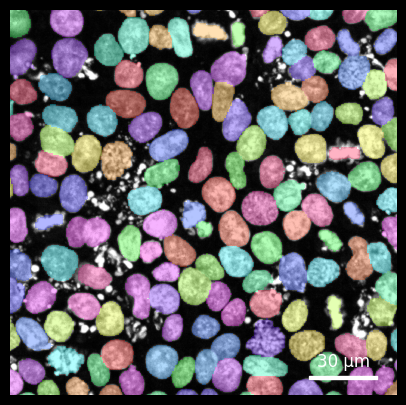

In [24]:
img.plot(label_name='nuclei',
         pyramid_level=0,
         upper_left_yx=(130, 140),
         lower_right_yx=(300, 310),
         scalebar_micrometer=30,
         scalebar_color='white',
         fig_width_inch=5,
         fig_height_inch=5,
         fig_dpi=100)

You may notice that the above will warn about no labels being available
for the requested intensity image pyramid level. The `plot` method will
automatically use the label with the closest resolution and scale it to
match the intensity image.

For your convenience, it is also possible to specify multiple label
names using a `list` (for example to reuse the same label name list when
working with multiple images that have different labels). `plot()` will
still only display a single label mask, namely the first one in the
provided list that is available for the image (so the order of label
names matters):

Using label_name='nuclei' for image cardio-d14

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/ez_zarr/ome_zarr.py:944: UserWarning: For the requested pyramid level (0) of the intensity image, no matching label ('nuclei') is available. Up-scaling the label using factor(s) [1. 4. 4.]
  warnings.warn(f"For the requested pyramid level ({pyramid_level}) of the intensity image, no matching label ('{lname}') is available. Up-scaling the label using factor(s) {scalefact_yx}")

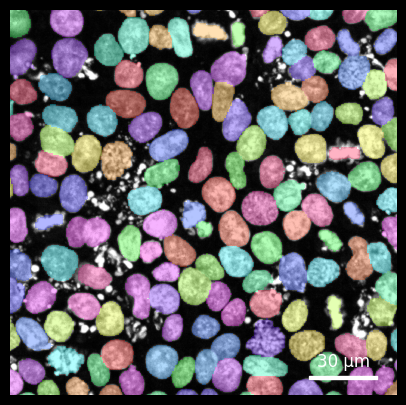

In [25]:
img.plot(label_name=['whole_cells', 'nuclei', 'mitochondria'],
         pyramid_level=0,
         upper_left_yx=(130, 140),
         lower_right_yx=(300, 310),
         scalebar_micrometer=30,
         scalebar_color='white',
         fig_width_inch=5,
         fig_height_inch=5,
         fig_dpi=100)

Using the `show_label_values` argument of `plotting.plot_image`, the
label values can be added (optionally also using the `label_fontsize`
and `label_text_colour` argument to ):

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/ez_zarr/ome_zarr.py:944: UserWarning: For the requested pyramid level (0) of the intensity image, no matching label ('nuclei') is available. Up-scaling the label using factor(s) [1. 4. 4.]
  warnings.warn(f"For the requested pyramid level ({pyramid_level}) of the intensity image, no matching label ('{lname}') is available. Up-scaling the label using factor(s) {scalefact_yx}")

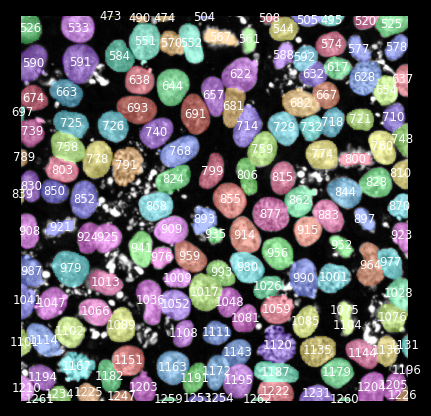

In [26]:
img.plot(show_label_values=True,
         label_fontsize='small',
         label_text_colour='white',
         label_name='nuclei',
         pyramid_level=0,
         upper_left_yx=(130, 140),
         lower_right_yx=(300, 310),
         fig_width_inch=5,
         fig_height_inch=5,
         fig_dpi=100)

If you are interested in a specific object, you can pass its value to
the `label_value` argument (and optionally use the `extend_pixels` and
`msk_alpha` arguments), to automatically select appropriate coordinates:

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/ez_zarr/ome_zarr.py:944: UserWarning: For the requested pyramid level (0) of the intensity image, no matching label ('nuclei') is available. Up-scaling the label using factor(s) [1. 4. 4.]
  warnings.warn(f"For the requested pyramid level ({pyramid_level}) of the intensity image, no matching label ('{lname}') is available. Up-scaling the label using factor(s) {scalefact_yx}")

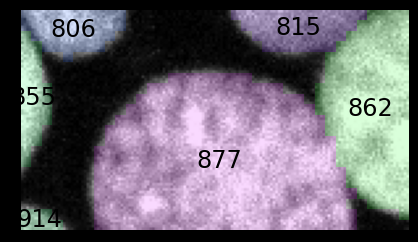

In [27]:
img.plot(label_value=877,
         extend_pixels=10,
         msk_alpha=0.15,
         show_label_values=True,
         label_fontsize='xx-large',
         label_text_colour='black',
         label_name='nuclei',
         pyramid_level=0,
         fig_width_inch=5,
         fig_height_inch=5,
         fig_dpi=100)

For performance reasons, the bounding box for an object given by
`label_value` is calculated on the lowest-resolution label image by
default. This may lead to imprecise results, as here where the lower
part of object 877 is truncated. To improve the precision of the
bounding box calculation, you can manually select the pyramid level to
be used, using the argument `label_pyramid_level`:

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/ez_zarr/ome_zarr.py:944: UserWarning: For the requested pyramid level (0) of the intensity image, no matching label ('nuclei') is available. Up-scaling the label using factor(s) [1. 4. 4.]
  warnings.warn(f"For the requested pyramid level ({pyramid_level}) of the intensity image, no matching label ('{lname}') is available. Up-scaling the label using factor(s) {scalefact_yx}")

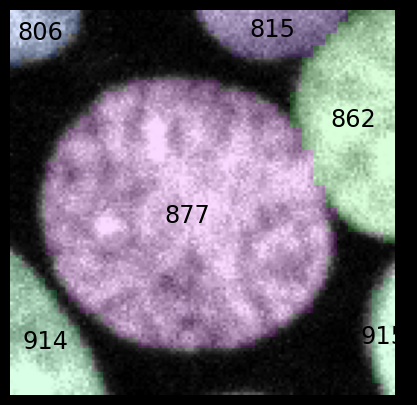

In [28]:
img.plot(label_value=877,
         label_pyramid_level='2',
         extend_pixels=10,
         msk_alpha=0.15,
         show_label_values=True,
         label_fontsize='xx-large',
         label_text_colour='black',
         label_name='nuclei',
         pyramid_level=0,
         fig_width_inch=5,
         fig_height_inch=5,
         fig_dpi=100)

If you want to restrict the plot to the exact are within that specific
object (or objects), you can use the `restrict_to_label_values` argument
and provide a list of values:

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/ez_zarr/ome_zarr.py:944: UserWarning: For the requested pyramid level (0) of the intensity image, no matching label ('nuclei') is available. Up-scaling the label using factor(s) [1. 4. 4.]
  warnings.warn(f"For the requested pyramid level ({pyramid_level}) of the intensity image, no matching label ('{lname}') is available. Up-scaling the label using factor(s) {scalefact_yx}")

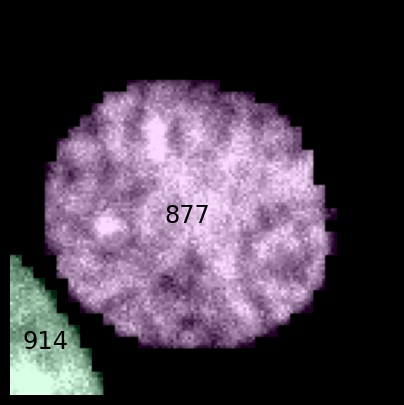

In [29]:
img.plot(label_value=877,
         label_pyramid_level='2',
         restrict_to_label_values=[877,914],
         extend_pixels=10,
         msk_alpha=0.15,
         show_label_values=True,
         label_fontsize='xx-large',
         label_text_colour='black',
         label_name='nuclei',
         pyramid_level=0,
         fig_width_inch=5,
         fig_height_inch=5,
         fig_dpi=100)

## Calculations on the image data

Let’s obtain again the intensity image data in the form of an array:

In [30]:
arr = img.get_array_by_coordinate()

To save memory, images are stored on disk and only loaded when needed
(for implementation details see the [`dask` Array
documentation](https://docs.dask.org/en/stable/array.html)).

This can be demonstrated by `type(arr)` and `sys.getsizeof(arr)`:

In [31]:
# note that the image is an 'on-disk' array
type(arr)

zarr.core.array.Array

In [32]:
sys.getsizeof(arr)

56

To force loading of the data into memory as a `numpy` array, you can
call `np.array(arr)`:

In [33]:
ndarr = np.array(arr) # triggers loading it into memory
type(np.array(ndarr))

numpy.ndarray

In [34]:
sys.getsizeof(ndarr)

86560

In general, you can use `dask` arrays like `numpy` arrays. For example,
we can threshold the image:

In [35]:
# threshold (will also trigger loading into memory)
arr_mask = arr[0,0]>300
type(arr_mask)

numpy.ndarray

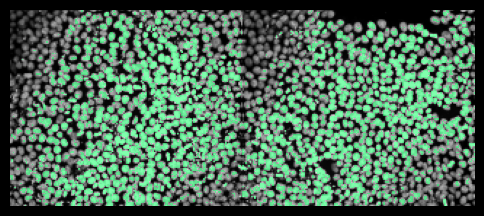

In [36]:
# plot 
plotting.plot_image(im=arr[:,0], msk=arr_mask, msk_alpha=0.5,
                    fig_width_inch=6, fig_height_inch=6, fig_dpi=100)

This is of course not a recommended way to segment this image, but
rather meant to demonstrate that the `dask` arrays can be used just like
`numpy` arrays.

Extracting arrays and plotting them directly with `plotting.plot_image`
is also the recommended way to do more complex tasks that are not
directly supported by the arguments in `Image.plot`. For example, you
could subset a 3D image to select just one or several z-planes of
interest, instead of using the automated projection
(`z_projection_method` argument of `plotting.plot_image`).

# Working with images with time dimension

Images that include a time dimension can also be handled using
`ez_zarr`. For plotting such images, you have to specify which time
index to plot.

For illustration, we first download a small example image (showing a
tubulin histone GFP coexpressing C. elegans embryo) that is part of the
`ez_zarr` GitHub repository. The original data set was acquired on a
multiphoton workstation by Josh Bembenek, and is freely available from
[openmicroscopy.org](https://docs.openmicroscopy.org/ome-model/5.6.3/ome-tiff/data.html).
The data set included in `ez_zarr` is a subset of the original image (2
timepoints, 1 channel, 2 z-planes). In addition, a manual segmentation
label was added for illustration purposes.

In [37]:
# download an image with a time axis
url = "https://github.com/fmicompbio/ez_zarr/archive/refs/heads/main.zip"

with tempfile.TemporaryDirectory() as temp_dir:
    response = requests.get(url)
    response.raise_for_status()  # raise an error if the request fails

    # download
    temp_zip_file = os.path.join(temp_dir, 'temp.zip')
    with open(temp_zip_file, 'wb') as temp_zip:
        temp_zip.write(response.content)

    # unzip to current directory
    with zipfile.ZipFile(temp_zip_file, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # locate the extracted folder
    extracted_folder = os.path.join(temp_dir, "ez_zarr-main", "tests",
                                    "example_data_5d")

    # move the image to current working directory
    if os.path.exists(extracted_folder):
        shutil.copytree(extracted_folder, ".", dirs_exist_ok=True)

Now we open the image:

In [38]:
img5d = ome_zarr.Image("tubhiswt4D_sub.zarr")
img5d.channel_info_image

'tczyx'

The time axis contains three entries:

In [39]:
print(img5d.tree(level=3))

/ 
├── 0 (3, 1, 2, 512, 512) uint8
├── 1 (3, 1, 2, 256, 256) uint8
├── 2 (3, 1, 2, 128, 128) uint8
└── labels 
 └── embryo 
 ├── 0 (3, 2, 512, 512) uint8
 ├── 1 (3, 2, 256, 256) uint8
 └── 2 (3, 2, 128, 128) uint8

We can plot selected timepoints by specifying the `time_index` argument
of `Image.plot()`:

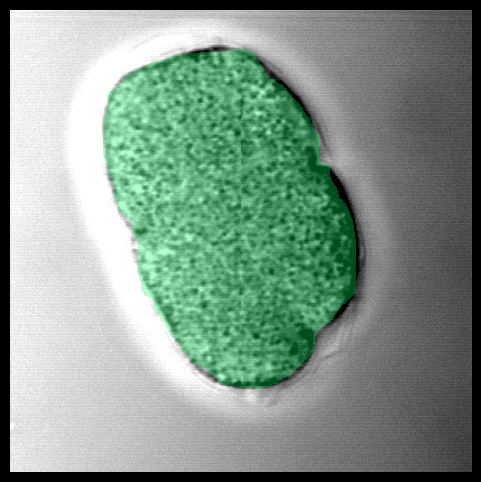

In [40]:
img5d.plot(time_index=0,
           pyramid_level=0,
           label_name="embryo",
           fig_width_inch=6,
           fig_height_inch=6,
           fig_dpi=100)

# Working with multiple images

In some cases, you may want to handle a set of images, such as images
corresponding to the well of an high-content screening plate. Such data
is represented in `ez_zarr` by `ome_zarr.ImageList` objects, and can be
created from a folder containing multiple images using the
`ome_zarr.import_plate` function:

In [41]:
img_directory = '20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr'
imgL = ome_zarr.import_plate(img_directory)
imgL

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/zarr/core/group.py:3530: ZarrUserWarning: Object at .DS_Store is not recognized as a component of a Zarr hierarchy.
  warnings.warn(
/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/zarr/core/group.py:3530: ZarrUserWarning: Object at empty_well_ROI_table_0_True_0_0 is not recognized as a component of a Zarr hierarchy.
  warnings.warn(
/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/zarr/core/group.py:3530: ZarrUserWarning: Object at empty_well_ROI_table_1_True_0_0 is not recognized as a component of a Zarr hierarchy.
  warnings.warn(
/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/zarr/core/group.py:3530: ZarrUserWarning: Object at table_well_ROI_table_3_False_0_0 is not recognized as a component of a Zarr hierarchy.
  warnings.warn(
/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/zarr/core/group.py:3530: ZarrUserWarning: Object at empt

ImageList of 1 images
  paths: 20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0
  names: B03

Note that as our example data only contains a single well, this image
list contains only a single image.

In [42]:
len(imgL)

1

All methods available to `ome_zarr.Image` can also be used for
`ome_zarr.ImageList` objects, and some have special behavior, for
example the plot method that arranges the wells in plate layout
(automatically determined to be compatible with the observed wells):

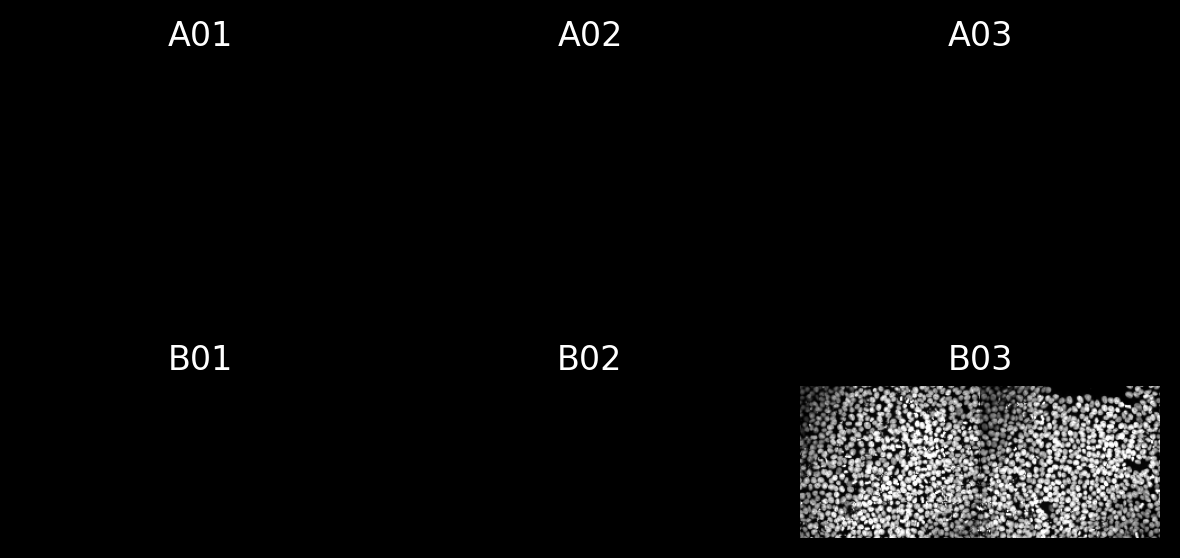

In [43]:
imgL.plot()

The detected layout can be returned as a `pandas.DataFrame`:

In [44]:
imgL.get_layout()

… and also set manually:

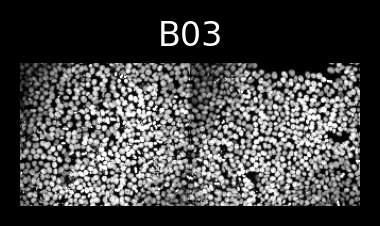

In [45]:
layout_df = pd.DataFrame.from_dict({'row_index': [1], 'column_index': [1]})
imgL.set_layout(layout_df)
imgL.plot()

# Session info

In [46]:
import session_info
session_info.show()

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)

Click to view session information 
 
-----
anndata 0.12.2
ez_zarr 0.4.2
matplotlib 3.8.2
numpy 1.26.4
pandas 2.3.2
requests 2.32.5
session_info 1.0.0
skimage 0.22.0
zarr 3.1.3
-----
 
 
 Click to view modules imported as dependencies 
 
PIL 11.3.0
anyio NA
arrow 1.3.0
asttokens NA
attr 25.3.0
attrs 25.3.0
babel 2.17.0
certifi 2025.08.03
charset_normalizer 3.4.3
cloudpickle 3.1.1
comm 0.2.3
crc32c NA
cycler 0.12.1
cython_runtime NA
dask 2025.9.1
dateutil 2.9.0.post0
debugpy 1.8.17
decorator 5.2.1
defusedxml 0.7.1
donfig 0.8.1.post1
executing 2.2.1
fastjsonschema NA
fqdn NA
fsspec 2025.9.0
h5py 3.14.0
idna 3.10
importlib_metadata NA
ipykernel 6.30.1
isoduration NA
jedi 0.19.2
jinja2 3.1.6
json5 0.12.1
jsonpointer 3.0.0
jsonschema 4.25.1
jsonschema_specifications NA
jupyter_events 0.12.0
jupyter_server 2.17.0
jupyterlab_server 2.27.3
kiwisolver 1.4.9
lark 1.2.2
lazy_loader 0.4
legacy_api_wrap NA
markupsafe 3.0.2
matplotlib_inline 0.1.7
mpl_toolkits NA
natsort 8.4.0
nbformat 5.10.4
numcodecs 0.16.3
overrides NA
packaging 25.0
parso 0.8.5
platformdirs 4.4.0
prometheus_client NA
prompt_toolkit 3.0.52
psutil 7.1.0
pure_eval 0.2.3
pydev_ipython NA
pydevconsole NA
pydevd 3.2.3
pydevd_file_utils NA
pydevd_plugins NA
pydevd_tracing NA
pygments 2.19.2
pyparsing 3.2.5
pythonjsonlogger NA
pytz 2025.2
referencing NA
rfc3339_validator 0.1.4
rfc3986_validator 0.1.1
rfc3987_syntax NA
rich NA
rpds NA
scipy 1.16.2
send2trash NA
six 1.17.0
sniffio 1.3.1
stack_data 0.6.3
tabulate 0.9.0
testing NA
tlz 1.0.0
toolz 1.0.0
tornado 6.5.2
traitlets 5.14.3
typing_extensions NA
uri_template NA
urllib3 2.5.0
wcwidth 0.2.13
webcolors NA
websocket 1.8.0
yaml 6.0.2
zipp NA
zmq 27.1.0
zoneinfo NA
 
 <!-- seems like this ends pre, so might as well be explicit -->
 
-----
IPython 9.5.0
jupyter_client 8.6.3
jupyter_core 5.8.1
jupyterlab 4.4.7
notebook 7.4.5
-----
Python 3.11.13 (main, Jun 4 2025, 04:12:12) [GCC 13.3.0]
Linux-6.11.0-1018-azure-x86_64-with-glibc2.39
-----
Session information updated at 2025-09-22 12:38